This notebook uses a neural network for data unfolding. It is made specifically for Halo1 at 5kpc. This specification is only because the neural network needs to be trained on a data set spanning the full range of possible 1n,2n values. For Halo1 at closer distances or Halo2, it needs to be trained on a wider range of 1n,2n values.

First a region of the 1n,2n plane is sampled, and each integer pair is simulation at a detection. These sets of truth,observed values are then scaled down to the size of the neural network. Then the scaled set of truth,observed values are used to feed the neural network. 

Then the 1n,2n points of interest are simulated, scaled to the NN size, unfolding is performed, then they are rescaled back to normal size. 

In [1]:
# Basic libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Neural Network
from keras.models import Sequential
from keras.layers import Dense

# My modules
from modules.efficiency_matrix import effmatrix

C:\Users\jfcre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# set the random seed
seed = 11
np.random.seed(seed)

#### Functions for use below:

In [3]:
# This function simulates detection in HALO for a given 1n,2n truth values

def observe(oneN,twoN):
    oneN_obs = 0
    twoN_obs = 0
    for n in range(oneN):
        rand = np.random.random()
        if rand < M.item(0,0):
            oneN_obs += 1
    for n in range(twoN):
        rand = np.random.random()
        if rand < M.item(0,1):
            oneN_obs += 1
        elif rand < M.item(0,1) + M.item(1,1):
            twoN_obs += 1
    return oneN_obs,twoN_obs

In [4]:
# This function converts a scatter plot to an array for use in the neural network
def scatter_to_hist(xarray,yarray):
    
    nbins = (NN_x_max + 1)*(NN_y_max + 1)
    hist = np.zeros(nbins)
    
    for i in range(len(xarray)):
        x = xarray[i]
        y = yarray[i]
        
        if oneN > 0 or twoN > 0:
            j = x + (NN_x_max + 1)*y
            hist[j] += 1
            
    return hist

# This function converts neural network arrays back into scatter plot arrays
def hist_to_scatter(array, integral=1):
    
    x_array = []
    y_array = []
    
    if integral == 1:
        cut = 0
    else:
        # Selecting the appropriate cut
        sort = -np.sort(-array)
        tot_prob = 0
        for i in sort:
            tot_prob += i
            if tot_prob >= integral:
                cut = i
                break
    
    for i in range(len(array)):
        if array[i] > cut:
            # calculate x,y values from index
            xval = i % (NN_x_max + 1)
            yval = i // (NN_x_max + 1)
            # add x,y to arrays for scatter plot
            x_array.append(xval)
            y_array.append(yval)
            
    return x_array,y_array

#### Creating Neural Network

In [5]:
# Setting up this neural network to be the right size for HALO1. 
# Here I am picking the largest 1n,2n value for Halo1 so that 
# the NN is large enough for all Halo1 values
Truth1n = 72
Truth2n = 48

In [45]:
# sample region in 1n,2n plane
min1n = 10
max1n = int(Truth1n+3*np.sqrt(Truth1n)+0.5)
min2n = 0
max2n = int(Truth2n+3*np.sqrt(Truth2n)+0.5)

# plot size (this is the max size that we scale down to NN size)
x_max = int(max1n+7*np.sqrt(max1n)+0.5)
y_max = int(max2n+7*np.sqrt(max2n)+0.5)

# plot size for NN
# (takes too much memory to do full size)
NN_x_max = 50
NN_y_max = 50

# how many times we sample the 2D-poisson dist. at a given (1n,2n) truth value
nsamples = 10

# HALO efficiency matrix
M = effmatrix()

# step size in sample region
# don't take steps smaller than NN resolution
xincr = max(int(max1n/NN_x_max+0.5),1)
yincr = max(int(max2n/NN_y_max+0.5),1)

In [46]:
# Sampling the region in the 1n x 2n plane

oneNtruth_set = []
twoNtruth_set = []
oneNobs_set   = []
twoNobs_set   = []

for k in range(nsamples):
    for i in range(min1n,max1n+1,xincr):
        for j in range(min2n,max2n,yincr):

            oneNtruth = []
            twoNtruth = []
            oneNobs   = []
            twoNobs   = []

            # truth distribution
            oneN = np.random.poisson(i)
            twoN = np.random.poisson(j)

            # calculate observed distribution
            oneN_obs,twoN_obs = observe(oneN,twoN)

            oneNtruth.append(oneN)
            twoNtruth.append(twoN)
            oneNobs.append(oneN_obs)
            twoNobs.append(twoN_obs)

            # add arrays to sets
            oneNtruth_set.append(oneNtruth)
            twoNtruth_set.append(twoNtruth)
            oneNobs_set.append(oneNobs)
            twoNobs_set.append(twoNobs)


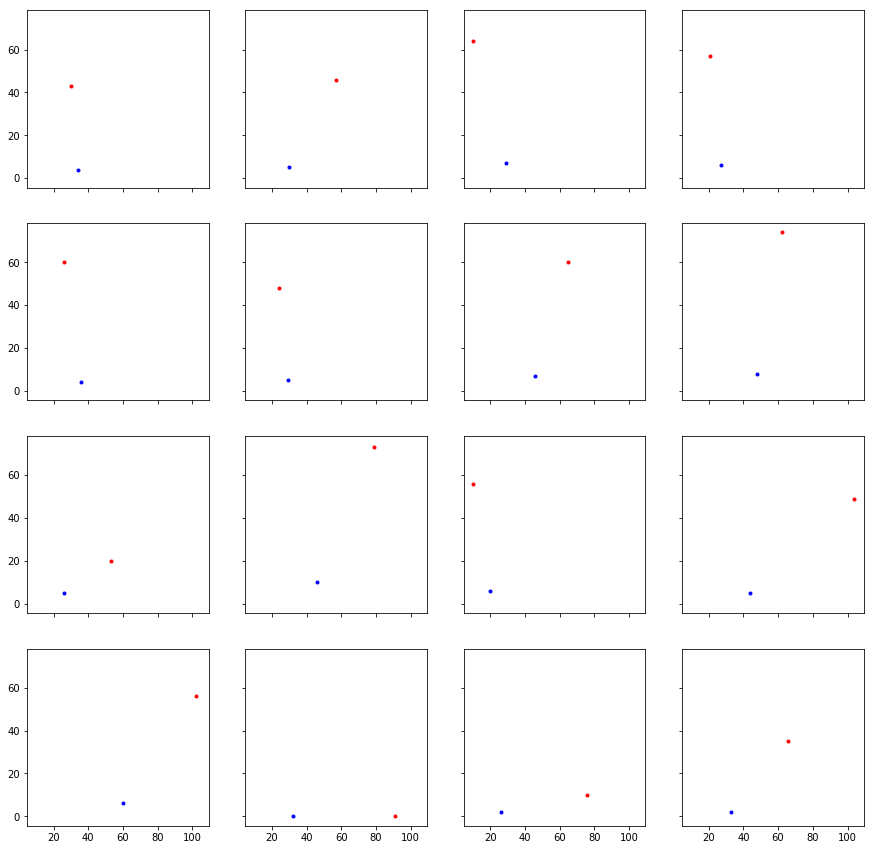

In [47]:
# Plot 16 random truth,observed sets for visual check
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15), sharex=True, sharey=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.2)

axs = axs.ravel()

for plot_ in range(16):
    
    plot_num = np.random.randint(0,len(oneNtruth_set))
            
    axs[plot_].scatter(oneNtruth_set[plot_num],twoNtruth_set[plot_num],c='r',marker='.',alpha=1)
    axs[plot_].scatter(oneNobs_set[plot_num],twoNobs_set[plot_num],c='b',marker='.',alpha=1)

In [48]:
# scale everything down to NN size
xscale = NN_x_max/x_max
yscale = NN_y_max/y_max
    
oneNtruth_set_scaled = np.array([np.array(i)*xscale for i in oneNtruth_set]).astype(int)
twoNtruth_set_scaled = np.array([np.array(i)*yscale for i in twoNtruth_set]).astype(int)
oneNobs_set_scaled   = np.array([np.array(i)*xscale for i in oneNobs_set]).astype(int)
twoNobs_set_scaled   = np.array([np.array(i)*yscale for i in twoNobs_set]).astype(int)

In [49]:
# convert scatter plots to NN arrays

truth_set = []
obs_set   = []

# add truths,observations to arrays
for i in range(len(oneNtruth_set_scaled)):
    
    oneNtruth = oneNtruth_set_scaled[i]
    twoNtruth = twoNtruth_set_scaled[i]
    oneNobs   = oneNobs_set_scaled[i]
    twoNobs   = twoNobs_set_scaled[i]
    
    truth = scatter_to_hist(oneNtruth,twoNtruth)
    obs   = scatter_to_hist(oneNobs,twoNobs)
    
    # add arrays to set
    truth_set.append(truth)
    obs_set.append(obs)


In [50]:
# standardize the data
# (Many training algorithms behave poorly if the data isn't 
# (approximately) normally distributed (i.e. Gaussian with 
# mean = 0 and unit variance))

scaler = StandardScaler()
# Fit the scaler
scaler.fit(obs_set)
# standardize the data
obs_set = scaler.transform(obs_set)

In [51]:
# The neural network. 
# It is a fully-connected (dense) feed-forward neural network

width = (NN_x_max+1)*(NN_y_max+1) # how many nodes in input
epochs = 2#4
batch_size = 32

model = Sequential()
model.add(Dense(width, input_dim=width, kernel_initializer='normal', activation='relu'))
model.add(Dense(width, kernel_initializer='normal', activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(obs_set, np.array(truth_set), epochs=epochs, batch_size=batch_size,verbose=1)

Epoch 1/2
30360/30360 [==============================] - 442s 15ms/step - loss: 0.0031 - acc: 0.9996
Epoch 2/2
30360/30360 [==============================] - 449s 15ms/step - loss: 0.0028 - acc: 0.9996


In [52]:
# Perform the unfolding
unfolded_set = model.predict(obs_set)

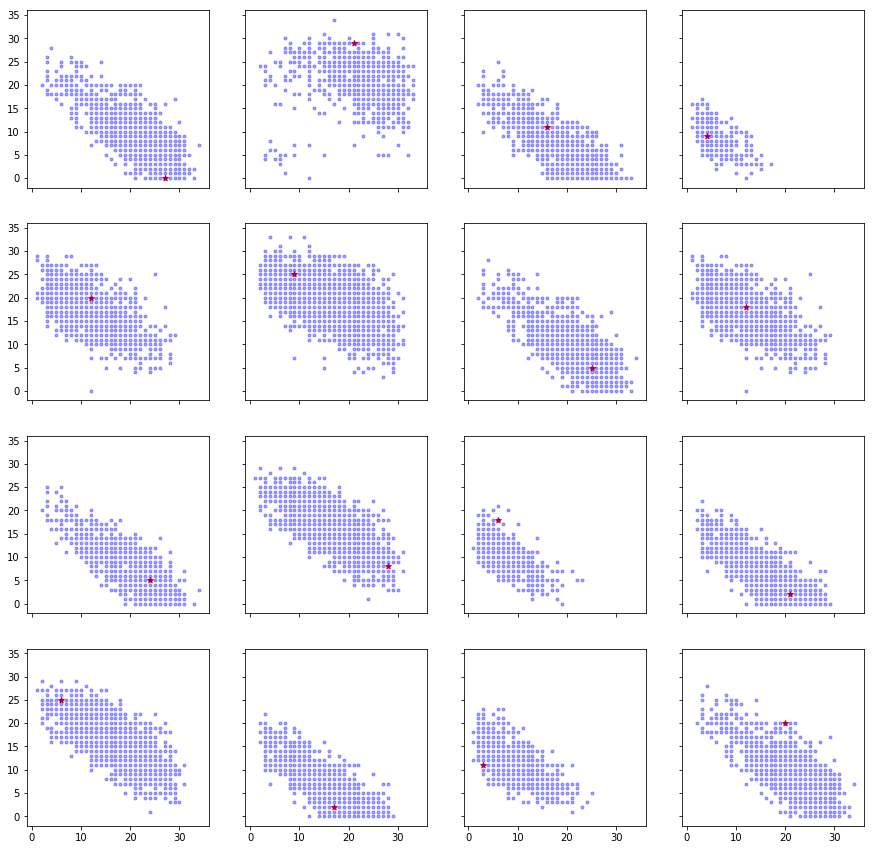

In [53]:
# Plot 16 examples
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15), sharex=True, sharey=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.2)

axs = axs.ravel()

for plot_ in range(16):
    
    plot_num = np.random.randint(0,len(unfolded_set))
    unfolded_plot = unfolded_set[plot_num]
    truth_plot = truth_set[plot_num]

    # arrays for scatter plot
    x_unfolded, y_unfolded = hist_to_scatter(unfolded_plot,integral=0.9)
    x_truth, y_truth = hist_to_scatter(truth_plot)
            
    axs[plot_].scatter(x_truth,y_truth,c='r',marker='*',alpha=1)
    axs[plot_].scatter(x_unfolded,y_unfolded,c='b',marker='.',alpha=0.35)
    

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------

#### Unfolding

In [54]:
# This function takes a 1n,2n truth value and does the unfolding

def unfold(Truth1n,Truth2n,xmin=0,xmax=x_max,ymin=0,ymax=y_max):
    
    # First generate a truth and observed distribution
    # -------------------------------------------------------
    oneNtruth = []
    twoNtruth = []
    oneNobs   = []
    twoNobs   = []

    # calculate observed distribution
    oneN_obs,twoN_obs = observe(Truth1n,Truth2n)

    oneNtruth.append(Truth1n)
    twoNtruth.append(Truth2n)
    oneNobs.append(oneN_obs)
    twoNobs.append(twoN_obs)
        
    # Second create data array for the neural network
    # -------------------------------------------------------

    # scale data down to Neural Network size
    xscale = NN_x_max/x_max
    yscale = NN_y_max/y_max
    oneNobs_scaled   = [int(i*xscale) for i in oneNobs]
    twoNobs_scaled   = [int(i*yscale) for i in twoNobs]
    
    # convert scatter plot to array
    obs = scatter_to_hist(oneNobs_scaled,twoNobs_scaled)
    
    # need an array of length batch_size
    obs_set = np.array([obs for i in range(batch_size)])
    
    # standardize the data
    obs_set = scaler.transform(obs_set)

    # Third unfold and plot the results
    # ------------------------------------------------------- 
    unfolded_set = model.predict(obs_set)
    unfolded = unfolded_set[0]
    
    # convert back to scatter plot
    x_unfolded, y_unfolded = hist_to_scatter(unfolded,integral=0.90)

    # rescale back to full size
    x_unfolded = [i/xscale for i in x_unfolded]
    y_unfolded = [i/yscale for i in y_unfolded]
    
    # Plot the results vs truth

    fig, ax = plt.subplots(1,1,figsize=(8,6))

    ax.scatter(oneNtruth,twoNtruth,c='r',marker='.',alpha=0.3)
    ax.scatter(x_unfolded,y_unfolded,c='b',marker='.',alpha=0.65)
    ax.scatter(Truth1n,Truth2n,c='white',edgecolor='black',marker='*',s=400)
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    
    plt.show()
    return x_unfolded,y_unfolded


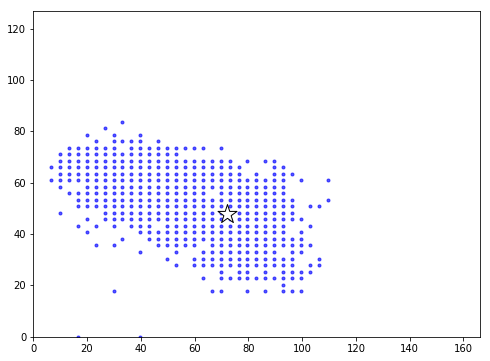

In [55]:
# HALO 1, 5kpc, 72 oneN, 48 twoN
x_unfolded_1, y_unfolded_1 = unfold(72,48)
save = [x_unfolded_1, y_unfolded_1]
#np.save('./unfolded_data/halo1_5kpc_72v48_unfolded_NN.npy',save)

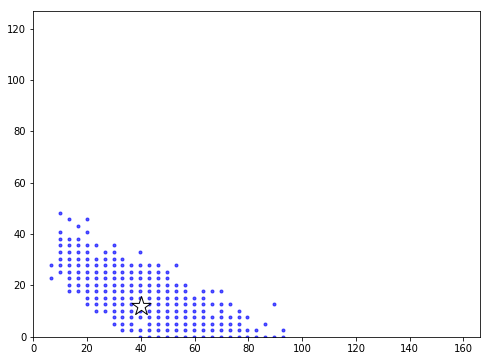

In [56]:
# HALO 1, 5kpc, 40 oneN, 12 twoN
x_unfolded_2, y_unfolded_2 = unfold(40,12)
save = [x_unfolded_2, y_unfolded_2]
#np.save('./unfolded_data/halo1_5kpc_40v12_unfolded_NN.npy',save)

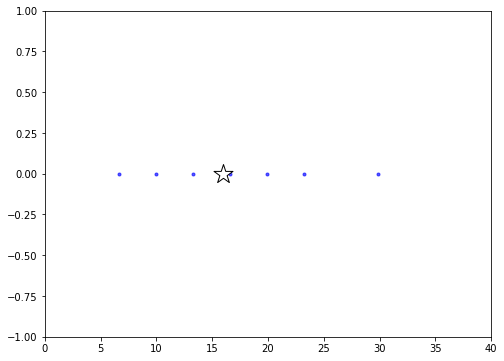

In [57]:
# HALO 1, 5kpc, 16 oneN, 0 twoN
x_unfolded_3, y_unfolded_3 = unfold(16,0,xmax=40,ymin=-1,ymax=1)
save = [x_unfolded_3, y_unfolded_3]
#np.save('./unfolded_data/halo1_5kpc_16v0_unfolded_NN.npy',save)